In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from tqdm.notebook import tqdm

In [13]:
df_listings = pd.read_csv("data/listings.csv")

df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [26]:
cols = ['id', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet',
       'price', 'weekly_price', 'monthly_price']

df_listings[cols].sort_values("id")

,id,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,weekly_price,monthly_price
3307,3353,42.355017,-71.127590,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,NaN,$40.00,$400.00,"$1,200.00"
780,5506,42.329809,-71.095595,t,House,Private room,2,1.0,1.0,1.0,Real Bed,225.0,$145.00,$980.00,"$3,000.00"
855,6695,42.329941,-71.093505,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,$195.00,NaN,NaN
2,6976,42.292438,-71.135765,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$65.00,$395.00,"$1,350.00"
2109,8792,42.358497,-71.062011,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,NaN,$154.00,$750.00,"$2,900.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,14924831,42.381921,-71.068837,t,House,Private room,1,1.0,1.0,1.0,Real Bed,NaN,$190.00,NaN,NaN
2789,14928000,42.300476,-71.076970,f,House,Private room,1,1.0,1.0,1.0,Real Bed,NaN,$55.00,NaN,NaN
3278,14928333,42.337349,-71.048150,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$90.00,NaN,NaN
176,14933380,42.324891,-71.113440,f,Apartment,Shared room,1,1.0,1.0,1.0,Real Bed,NaN,$49.00,NaN,NaN


In [206]:
def distanceCoords(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad    

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

def createDistanceMatrix(df):
    rows = df.shape[0]
    all_coords = df[['latitude', 'longitude']].to_numpy()

    distance_matrix = np.zeros((rows, rows))

    for i in range(rows):
        coords = all_coords[i]
        distance = distanceCoords(coords[0], coords[1], all_coords[:, 0], all_coords[:, 1])
        distance_matrix[:, i] = distance

    return distance_matrix

def createSimilarityMatrix(distance_matrix, sim_type='inverse', **kwargs):
    if (sim_type == 'inverse'):
        #ignore the warning for divide by zero
        similarity_matrix = np.where(distance_matrix != 0, 1 / distance_matrix**2, 1000)
        similarity_matrix = np.clip(similarity_matrix, 0, 1000)
    
    elif (sim_type == 'rbf'):
        similarity_matrix = np.exp(-distance_matrix**2 / (2 * kwargs['sigma']**2))

    else:
        return

    return similarity_matrix


def calculateSparsity(matrix):
    nrEntries = matrix.shape[0]**2
    nrZeros = nrEntries - np.count_nonzero(matrix)
    return nrZeros*100 / nrEntries

In [ ]:
distanceMatrix = createDistanceMatrix(df_listings)

C:\Users\erena\AppData\Local\Temp\ipykernel_42628\970546105.py:37: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix = np.where(distance_matrix != 0, 1 / distance_matrix**2, 1000)


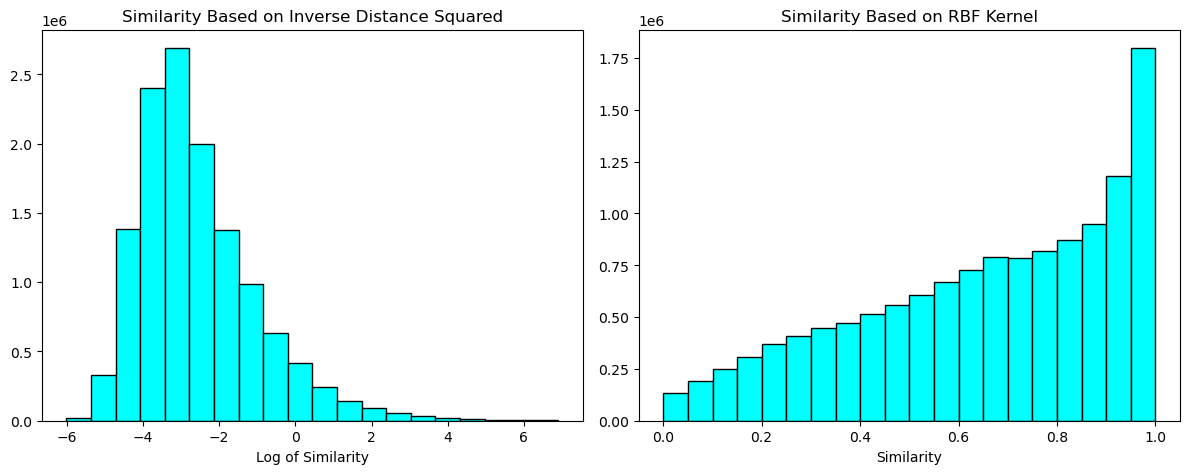

In [228]:
sim_distance = createSimilarityMatrix(distanceMatrix)
sim_rbf = createSimilarityMatrix(distanceMatrix, sim_type='rbf', sigma=5)

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].hist(np.log(sim_distance.flatten()), bins=20, edgecolor='black', color='cyan')
ax[0].set_xlabel("Log of Similarity")
ax[0].set_title("Similarity Based on Inverse Distance Squared")

ax[1].hist(sim_rbf.flatten(), bins=20, edgecolor='black', color='cyan')
ax[1].set_xlabel("Similarity")
ax[1].set_title("Similarity Based on RBF Kernel")

fig.tight_layout()

fig.savefig("figures/similarity_histogram.pdf")

In [29]:
df_calendar = pd.read_csv("data/calendar.csv")

df_calendar = df_calendar.groupby("listing_id").filter(lambda x: not x['price'].isna().all())

len(set(df_calendar['listing_id']))